<a href="https://colab.research.google.com/github/bhuvanabasapur/CMPE-297/blob/main/Assignments/Assignment%201/CMPE297_Assignment1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SimCLR Implementation in Pytorch

The 4 components of SimCLR are: 

 1) **Data Augmentation Module** to transform the dara stochastically to generae two correlated views of the same example. 

  2) **Base Encoder** for example ResNet-50 will be used to extract representation vectors from the augmented samples (through the final average pooling layer)

  3) **Projection Head** or MLP withone hidden layer to map the representations from the base encoder to 128 dimensional latent space where loss is applied and uses Relu activation function

  4) **Contrastive Loss function **

In [1]:
!nvidia-smi

Wed Sep 29 05:47:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import torch
from torchvision import transforms as T
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, resnet50

import os
from PIL import Image
from collections import OrderedDict

import random

import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

##Obtaining the dataset: 
Source: https://github.com/thunderInfy/imagenet-5-categories
https://github.com/mf1024/ImageNet-Datasets-Downloader 

In [3]:
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 30.48 MiB/s, done.
Resolving deltas: 100% (1/1), done.


### Creating train and test images

In [4]:
train_directory = sorted(os.listdir('/content/imagenet-5-categories/train'))
test_directory = sorted(os.listdir('/content/imagenet-5-categories/test'))
random.seed(3)
train_files = random.sample(train_directory, len(train_directory))
test_files = random.sample(test_directory, len(test_directory))
print(f'Train Data size: ', len(train_files))
print(f'Test Data Size: ', len(test_files))

Train Data size:  1250
Test Data Size:  250


In [5]:
test_files

['elephant_67028545_4df7a600ce.jpg',
 'car_1260288332_8f3ec15630.jpg',
 'dog_431241943_809206eedb.jpg',
 'airplane_2315183009_7a1a42e53d.jpg',
 'dog_355633623_dbace3e0c3.jpg',
 'cat_468615076_a2450bf20b.jpg',
 'airplane_2576984819_daa8e59e75.jpg',
 'dog_437176079_947526e681.jpg',
 'dog_1460011399_85bf054ef1.jpg',
 'elephant_171242004_b9c098a9a3.jpg',
 'airplane_26176200_25bd110677.jpg',
 'elephant_541037016_ecfa6df5e5.jpg',
 'elephant_529299460_829382d065.jpg',
 'elephant_1512248794_a732f0d77c.jpg',
 'elephant_2211547306_caca11f275.jpg',
 'airplane_108887665_86a1047ae4.jpg',
 'car_2431313043_0726effd05.jpg',
 'dog_3127747_8b48b6cbb6.jpg',
 'airplane_2238500615_0331fa9a26.jpg',
 'cat_157662884_8e2d1dd295.jpg',
 'car_2405552020_ee3df8170e.jpg',
 'cat_310343121_dc734b21fa.jpg',
 'cat_2095245869_167f4df935.jpg',
 'elephant_290934359_df434fea07.jpg',
 'car_2470019607_20dca68cb4.jpg',
 'cat_527547399_7f7b3c6157.jpg',
 'cat_754108251_f92d09ee98.jpg',
 'airplane_2043159074_1b5dabcb37.jpg',
 'a

In [6]:
mapping = {"cat": 0, "dog": 1, "elephant": 2, "car": 3, "airplane": 4} # mapping for each of the classes based on the filenames
train_labels, test_labels = [mapping[x.split("_")[0]]for x in train_files], [mapping[x.split("_")[0]] for x in test_files] 
print(train_labels)

[3, 2, 2, 3, 1, 2, 1, 2, 4, 2, 4, 1, 0, 2, 3, 3, 1, 2, 2, 1, 1, 3, 3, 3, 2, 1, 4, 4, 3, 2, 4, 0, 4, 0, 1, 1, 1, 1, 2, 1, 3, 0, 4, 4, 3, 2, 3, 0, 1, 2, 1, 2, 1, 2, 0, 2, 1, 3, 0, 4, 0, 3, 0, 2, 2, 2, 4, 3, 2, 0, 0, 3, 4, 1, 1, 4, 0, 4, 1, 2, 4, 0, 2, 1, 4, 4, 4, 1, 0, 2, 0, 2, 3, 2, 0, 4, 4, 4, 2, 4, 3, 1, 0, 0, 3, 4, 0, 0, 0, 3, 2, 1, 1, 2, 2, 4, 2, 0, 1, 3, 2, 1, 2, 2, 0, 2, 0, 4, 2, 0, 2, 2, 3, 4, 0, 1, 0, 2, 2, 2, 4, 4, 4, 1, 0, 1, 0, 0, 3, 0, 3, 0, 2, 0, 0, 1, 4, 4, 3, 2, 2, 3, 2, 3, 0, 3, 1, 4, 4, 0, 0, 3, 1, 3, 4, 2, 3, 1, 0, 3, 4, 4, 3, 0, 3, 0, 0, 4, 0, 3, 2, 2, 2, 1, 0, 1, 0, 1, 1, 4, 1, 2, 3, 4, 1, 2, 1, 3, 4, 1, 0, 0, 3, 4, 0, 4, 0, 2, 4, 3, 1, 4, 2, 1, 2, 3, 0, 4, 0, 4, 0, 0, 3, 4, 1, 2, 0, 4, 3, 4, 3, 1, 1, 0, 2, 1, 1, 4, 3, 4, 4, 4, 0, 1, 1, 4, 2, 2, 1, 3, 1, 2, 1, 2, 1, 2, 4, 3, 0, 0, 2, 3, 4, 1, 3, 2, 3, 0, 2, 0, 3, 4, 3, 3, 1, 1, 4, 1, 4, 2, 2, 4, 4, 2, 4, 3, 4, 2, 0, 4, 0, 2, 0, 3, 4, 3, 2, 3, 3, 0, 3, 0, 3, 3, 3, 4, 3, 3, 4, 4, 0, 4, 0, 0, 3, 1, 4, 0, 4, 2, 3, 3, 0, 

In [7]:
#Will use 10% of data to train on linear classifier
train_10_percent = random.sample(train_directory, len(train_directory)//10)
train_10_percent_labels = [mapping[x.split('_')[0]] for x in train_10_percent]

##Data Augmentation Module

In [8]:
class MyDataset(Dataset):
    def __init__(self, root_dir, filenames, labels, mutation=False):
        self.root_dir = root_dir
        self.file_names = filenames
        self.labels = labels
        self.mutation = mutation

    def __len__(self):
        return len(self.file_names)

    def tensorify(self, img):
        res = T.ToTensor()(img)
        res = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(res)
        return res

    def mutate_image(self, img):
        res = T.RandomResizedCrop(224)(img)
        res = get_color_distortion(1)(res)
        return res

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.file_names[idx])
        image = Image.open(img_name)
        label = self.labels[idx]
        image = T.Resize((250, 250))(image)

        if self.mutation:
            image1 = self.mutate_image(image)
            image1 = self.tensorify(image1)
            image2 = self.mutate_image(image)
            image2 = self.tensorify(image2)
            sample = {'image1': image1, 'image2': image2, 'label': label}
        else:
            image = T.Resize((224, 224))(image)
            image = self.tensorify(image)
            sample = {'image': image, 'label': label}

        return sample

In [9]:
def get_color_distortion(s=1.0):
    #s = strength of color distortion
    color_jitter = T.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    rnd_color_jitter = T.RandomApply([color_jitter], p=0.8)
    # p is the probability of grey scale
    rnd_gray = T.RandomGrayscale(p=0.2)# p is the probability of grayscale, here 0.2
    color_distort = T.Compose([rnd_color_jitter, rnd_gray])
    
    return color_distort

Perform data augmentation on the train and test datasets

In [10]:
#datasets
mutated_training_dataset = MyDataset('/content/imagenet-5-categories/train', train_directory, train_labels, mutation=True)
training_dataset = MyDataset('/content/imagenet-5-categories/train', train_10_percent, train_10_percent_labels, mutation=False)
testing_dataset = MyDataset('/content/imagenet-5-categories/train', test_directory, test_labels, mutation=False)

In [11]:
#dataloaders
dataloader_mutated_training_dataset = DataLoader(mutated_training_dataset, batch_size=125, shuffle=True, num_workers=2)
dataloader_training_dataset = DataLoader(training_dataset, shuffle=True, batch_size=125, num_workers=2)
dataloader_testing_dataset = DataLoader(testing_dataset, batch_size=125, num_workers=2, shuffle=True)



##Base Encoder Module

In [12]:
# To extract representation vectors from the augmented samples using Resnet50

# defining our deep learning architecture
resnet = resnet18(pretrained=False)

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(resnet.fc.in_features, 100)),
    ('added_relu1', nn.ReLU(inplace=True)),
    ('fc2', nn.Linear(100, 50)),
    ('added_relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(50, 25))
]))

resnet.fc = classifier

In [13]:
#move resnet to device
device = 'cpu'
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##Loss Function Module
NT-Xent Loss function

In [14]:
tau = 0.05

def loss_function(a, b):
    # a, b are vectors containing N representations of the augmented images
    a_norm = torch.norm(a, dim=1).reshape(-1, 1)
    a_cap = torch.div(a, a_norm)
    b_norm = torch.norm(b, dim=1).reshape(-1, 1)
    b_cap = torch.div(b, b_norm)
    a_cap_b_cap = torch.cat([a_cap, b_cap], dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap, a_cap], dim=0)
    sim = torch.mm(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = torch.div(sim, tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap, b_cap_a_cap), tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators, denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

##Projection Head Module

In [15]:
#setting up the optimizer
train_losses = []
num_epochs = 10
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [16]:
#directory to store results

# create directory to save the training results
if not os.path.exists('results'):
    os.makedirs('results')

In [17]:
# variable to chose to perform training
TRAINING = True 

In [18]:
def get_mean_of_list(L):
    return sum(L) / len(L)

In [19]:
print(enumerate(dataloader_mutated_training_dataset))

In [20]:
if TRAINING:
    # get resnet in train mode
    resnet.train()

    # run a for loop for num_epochs
    for epoch in range(num_epochs):

        # a list to store losses for each epoch
        epoch_losses_train = []

        # run a for loop for each batch
        for (_, sample_batched) in enumerate(dataloader_mutated_training_dataset):
            #print(sample_batched)
            # zero out grads
            optimizer.zero_grad()

            # retrieve x1 and x2 the two image batches
            x1 = sample_batched['image1']
            x2 = sample_batched['image2']

            # move them to the device
            x1 = x1.to(device)
            x2 = x2.to(device)

            # get their outputs
            y1 = resnet(x1)
            y2 = resnet(x2)

            # get loss value
            loss = loss_function(y1, y2)
            
            # put that loss value in the epoch losses list
            epoch_losses_train.append(loss.cpu().data.item())

            # perform backprop on loss value to get gradient values
            loss.backward()

            # run the optimizer
            optimizer.step()

        # append mean of epoch losses to losses_train, essentially this will reflect mean batch loss
        train_losses.append(get_mean_of_list(epoch_losses_train))

        # Plot the training losses Graph and save it
        fig = plt.figure(figsize=(10, 10))
        sns.set_style('darkgrid')
        plt.plot(train_losses)
        plt.legend(['Training Losses'])
        plt.savefig('losses.png')
        plt.close()

        # Store model and optimizer files
        torch.save(resnet.state_dict(), 'results/model.pth')
        torch.save(optimizer.state_dict(), 'results/optimizer.pth')
        np.savez("results/lossesfile", np.array(train_losses))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


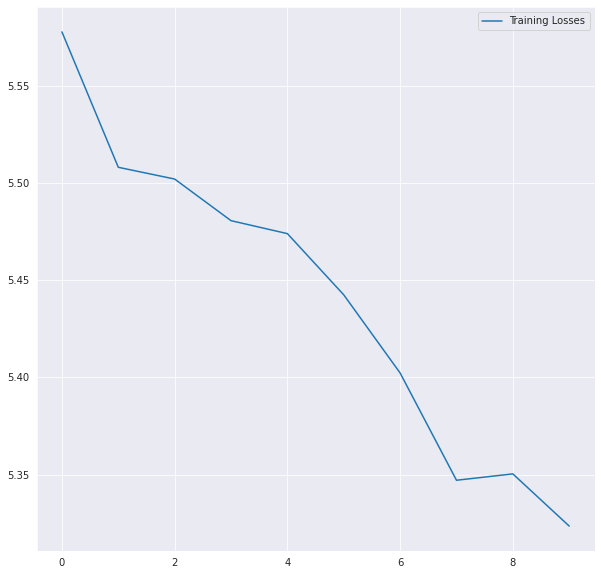

In [21]:
# Plot the training losses Graph and save it
def plot_loss(loss):
  fig = plt.figure(figsize=(10, 10))
  sns.set_style('darkgrid')
  plt.plot(loss)
  plt.legend(['Training Losses'])
  #plt.savefig('losses.png')
  #plt.close()

plot_loss(train_losses)

##TSNE Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


FileNotFoundError: ignored

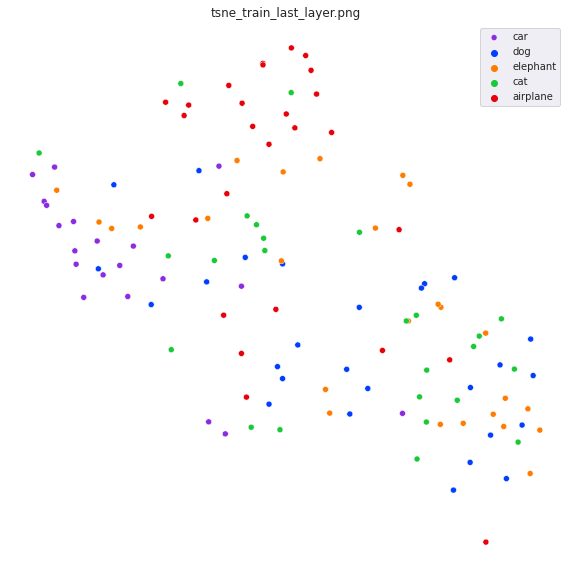

In [22]:
# a function used to plot t-SNE visualizations
def plot_vecs_n_labels(v,labels,fname):
    fig = plt.figure(figsize = (10, 10))
    plt.axis('off')
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.legend(['car', 'dog', 'elephant','cat','airplane'])
    plt.title(fname)
    #plt.savefig(fname)
    #plt.close()

# Boolean variable to control whether to perform t-SNE visualization or not
#TSNEVIS = False
TSNEVIS = True

if TSNEVIS:
    # run resnet in eval mode
    resnet.eval()

    # get TSNE visualizations of 10% training dataset
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_train_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

    # get TSNE visualizations of testing dataset
    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_test_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

# Removing the last layer and the relu layer, we remove layers incrementally and look t-SNE visualizations
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-2])

if TSNEVIS:
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_train_second_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_test_second_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

# removing one more layer, our entire projection head will be removed after this
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-1])

if TSNEVIS:
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_hidden_train.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_hidden_test.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None